### All the following cells are runable

In [1]:
# Our setup
import torch
from torch.functional import F

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu" if not torch.cuda.is_available() else "cuda:1"

import copy
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from sad_nns.uncertainty import *
from neurops import *

In [2]:
model = ModSequential(
        # ModLinear(784, 64, masked=True, prebatchnorm=True, learnable_mask=True),
        # ModLinear(64, 64, masked=True, prebatchnorm=True, learnable_mask=True),
        # ModLinear(64, 64, masked=True, prebatchnorm=True, learnable_mask=True),
        # ModLinear(64, 10, masked=True, prebatchnorm=True, nonlinearity=""),
        # ModLinear(784, 66),
        # ModLinear(66, 103),
        # ModLinear(103, 103),
        # ModLinear(103, 10,nonlinearity=""),
        ModConv2d(in_channels=1, out_channels=8, kernel_size=7, padding=1),
        ModConv2d(in_channels=8, out_channels=16, kernel_size=7, padding=1),
        ModConv2d(in_channels=16, out_channels=16, kernel_size=5),
        ModLinear(64, 32),
        ModLinear(32, 10, nonlinearity=""),
        # ModLinear(784, 64),
        # ModLinear(64, 64),
        # ModLinear(64, 64),
        # ModLinear(64, 10,nonlinearity=""),
        track_activations=False,
        track_auxiliary_gradients=True,
    #    input_shape = (784)
       input_shape = (1, 14, 14)
    ).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

print("This model has {} effective parameters.".format(model.parameter_count(masked = False)))
print("The conversion factor of this model is {} after layer {}.".format(model.conversion_factor, model.conversion_layer))

This model has 15514 effective parameters.
The conversion factor of this model is 4 after layer 2.


In [4]:
# for saving activations
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# manual save of activation
for i in range(len(model)-1):
    model[i].register_forward_hook(get_activation(str(i)))

In [5]:
batch_size = 128
epsilon = 0.01
total_epoch = 16
train_accs= []
test_accs = []
epochs = np.arange(total_epoch)

In [6]:
dataset = datasets.MNIST('../data', train=True, download=True,
                     transform=transforms.Compose([ 
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,)),
                            transforms.Resize((14,14))
                            # transforms.Resize((28,28)),
                            # transforms.Lambda(lambda x: torch.flatten(x))
                        ]))
train_set, val_set = torch.utils.data.random_split(dataset, lengths=[int(0.9*len(dataset)), int(0.1*len(dataset))])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,)),
                            transforms.Resize((14,14))
                            # transforms.Resize((28,28)),
                            # transforms.Lambda(lambda x: torch.flatten(x))
                        ])),
    batch_size=batch_size, shuffle=True)

def train(model, train_loader, optimizer, criterion, epochs=10, val_loader=None, verbose=True):
    model.train()

    train_accs = []
    test_accs = []

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0 and verbose:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
        
        correct = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)   
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            # print(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()
        train_acc = 100. * correct / len(train_loader.dataset)
        train_accs.append(train_acc)

        if val_loader is not None:
            print("Validation: ", end = "")
            ta = test(model, val_loader, criterion)
            test_accs.append(ta)

    return train_accs, test_accs

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    print('Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return 100. * correct / len(test_loader.dataset)

In [7]:
train_acc,test_acc = train(model, train_loader, optimizer, criterion, epochs=1, val_loader=val_loader)
train_accs += train_acc
test_accs += test_acc

# print("----------------------")
# print('Train accs: ', train_accs)
# print('Test accs: ', test_accs)
# print("The model now has {} effective parameters.".format(model.parameter_count(masked = False)))
# plt.plot(epochs, train_accs, label='Training Accuracy', color='blue')
# plt.plot(epochs, test_accs, label='Testing Accuracy', color='purple')
# plt.title('Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Value')
# plt.ylim(0, 100)
# plt.legend()
# plt.show()

/home/wangy51/senior_research/.venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train Epoch: 0 [0/54000 (0%)]	Loss: 2.315079
Train Epoch: 0 [12800/54000 (24%)]	Loss: 2.299212
Train Epoch: 0 [25600/54000 (47%)]	Loss: 2.276249
Train Epoch: 0 [38400/54000 (71%)]	Loss: 2.272042
Train Epoch: 0 [51200/54000 (95%)]	Loss: 2.164489
Validation: Average loss: 0.0168, Accuracy: 1766/6000 (29.43%)


Layer 0 score: 0.0714285746216774/8, neurons to add: 0
Layer 1 score: 0.133928582072258/16, neurons to add: 0
Layer 2 score: 0.133928582072258/16, neurons to add: 0
Layer 3 score: 0.0803571492433548/32, neurons to add: 0
The grown model now has 15514 effective parameters.
Validation after growing: Average loss: 0.0168, Accuracy: 1766/6000 (29.43%)
Validation: Average loss: 0.0043, Accuracy: 5021/6000 (83.68%)
Layer 0 score: 0.0714285746216774/8, neurons to add: 0
Layer 1 score: 0.1428571492433548/16, neurons to add: 0
Layer 2 score: 0.1428571492433548/16, neurons to add: 0
Layer 3 score: 0.2410714328289032/32, neurons to add: 5
The grown model now has 15514 effective parameters.
Validation after growing: Average loss: 0.0043, Accuracy: 5021/6000 (83.68%)
Validation: Average loss: 0.0034, Accuracy: 5221/6000 (87.02%)
Layer 0 score: 0.0714285746216774/8, neurons to add: 0
Layer 1 score: 0.1428571492433548/16, neurons to add: 0
Layer 2 score: 0.1428571492433548/16, neurons to add: 0
Layer

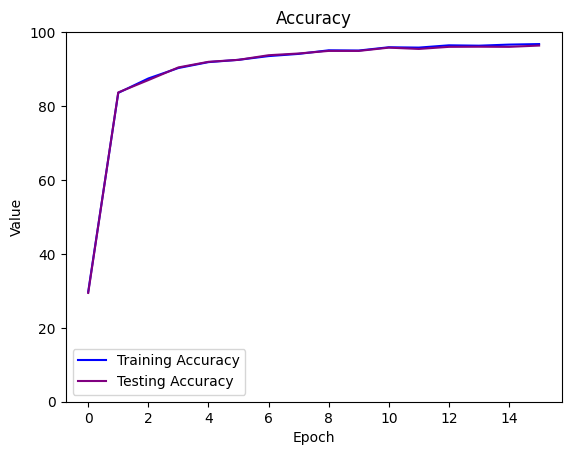

Layer 0 weight matrix after growth torch.Size([8, 1, 7, 7])
Layer 1 weight matrix after growth torch.Size([16, 8, 7, 7])
Layer 2 weight matrix after growth torch.Size([16, 16, 5, 5])
Layer 3 weight matrix after growth torch.Size([174, 64])
Layer 4 weight matrix after growth torch.Size([10, 174])
The grown model now has 15514 effective parameters.
Average loss: 0.0010, Accuracy: 5782/6000 (96.37%)


96.36666666666666

In [8]:
modded_model_grow = copy.deepcopy(model)
modded_optimizer_grow = torch.optim.SGD(modded_model_grow.parameters(), lr=0.01)
modded_optimizer_grow.load_state_dict(optimizer.state_dict())
initial_scores = []

for iter in range(12):
    for i in range(len(modded_model_grow)-1):
        # print("The size of activation of layer {}: {}".format(i, modded_model_grow.activations[str(i)].shape))
        # print("The size of my activation of layer {}: {}".format(i, activation[str(i)].shape))
        #score = orthogonality_gap(modded_model_grow.activations[str(i)])
        max_rank = modded_model_grow[i].width()
        # score = NORTH_score(modded_model_grow.activations[str(i)], batchsize=batch_size)
        score = NORTH_score(activation[str(i)], batchsize=batch_size, threshold=epsilon)
        # score = NORTH_score(modded_model_grow[i].weight, batchsize=batch_size)
        if iter == 0:
            initial_scores.append(score)
        initScore = 0.97 * initial_scores[i]
        to_add = max(0, int(modded_model_grow[i].weight.size()[0] * (score - initScore)))
        print("Layer {} score: {}/{}, neurons to add: {}".format(i, score, max_rank, to_add))

        # "iterative_orthogonalization", "kaiming_uniform", and "autoinit" are the three options in function north_select, "autoinit" not working
        # modded_model_grow.grow(i, to_add, fanin_weights="iterative_orthogonalization", 
        #                        optimizer=modded_optimizer_grow)
        modded_model_grow.grow(i, to_add, fanin_weights="kaiming_uniform", 
                               optimizer=modded_optimizer_grow)
        # modded_model_grow.grow(i, to_add, fanin_weights="autoinit")
       
    print("The grown model now has {} effective parameters.".format(modded_model_grow.parameter_count(masked = False)))
    print("Validation after growing: ", end = "")
    test(modded_model_grow, val_loader, criterion)
    train_acc,test_acc = train(modded_model_grow, train_loader, modded_optimizer_grow, criterion, epochs=1, val_loader=val_loader, verbose=False)
    train_accs += train_acc
    test_accs += test_acc
train_acc,test_acc = train(modded_model_grow, train_loader, modded_optimizer_grow, criterion, epochs=3, val_loader=val_loader)
train_accs += train_acc
test_accs += test_acc
print("----------------------")
print('Train accs: ', train_accs)
print('Test accs: ', test_accs)
plt.plot(epochs, train_accs, label='Training Accuracy', color='blue')
plt.plot(epochs, test_accs, label='Testing Accuracy', color='purple')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0, 100)
plt.legend()
plt.show()


for j in range(len(modded_model_grow)):
    print("Layer {} weight matrix after growth {}".format(j, modded_model_grow[j].weight.size()))
print("The grown model now has {} effective parameters.".format(modded_model_grow.parameter_count(masked = False)))
test(modded_model_grow, val_loader, criterion)

In [8]:
NORTH_score(activation[str(i)], batchsize=batch_size, threshold=epsilon)

tensor(0.2500, device='cuda:1')

In [9]:
print(activation[str(0)].shape)
print(activation[str(1)].shape)
print(activation[str(2)].shape)

torch.Size([112, 8, 10, 10])
torch.Size([112, 16, 6, 6])
torch.Size([112, 16, 2, 2])


In [10]:
# train(modded_model_grow, train_loader, modded_optimizer_grow, criterion, epochs=1, val_loader=val_loader)

In [11]:
modded_model_grow.grow(2, 2, fanin_weights="kaiming_uniform", 
                               optimizer=modded_optimizer_grow)

In [12]:
for j in range(len(modded_model_grow)):
    print("Layer {} weight matrix after growth {}".format(j, modded_model_grow[j].weight.size()))
print("The grown model now has {} effective parameters.".format(modded_model_grow.parameter_count(masked = False)))

Layer 0 weight matrix after growth torch.Size([8, 1, 7, 7])
Layer 1 weight matrix after growth torch.Size([16, 8, 7, 7])
Layer 2 weight matrix after growth torch.Size([18, 16, 5, 5])
Layer 3 weight matrix after growth torch.Size([83, 72])
Layer 4 weight matrix after growth torch.Size([10, 83])
The grown model now has 15514 effective parameters.
